In [12]:
from textstat import textstat
import re
import os
import en_core_web_sm
import numpy as np
import pandas as pd

nlp = en_core_web_sm.load()

POS_TAGS = [
    "ADJ",
    "ADP",
    "ADV",
    "AUX",
    "CONJ",
    "CCONJ",
    "DET",
    "INTJ",
    "NOUN",
    "NUM",
    "PART",
    "PRON",
    "PROPN",
    "PUNCT",
    "SCONJ",
    "SYM",
    "VERB",
    "X",
    "SPACE",
]


def generate_features(data):
    """Generate features for a list of texts

    Args:
        data (list[str]): the dataset to be processed.

    Returns:
        pandas.DataFrame: the processed features.
    """
    feature_data = []

    for text in data:
        features = preprocess_text(text)
        feature_data.append(features)

    return pd.DataFrame(feature_data)


def preprocess_text(text):
    """Takes a text, generate features, and returns as dict

    Args:
        text (str): the text to be preprocessed.

    Returns:
        dict: a dictionary of feature names with associated values

    """
    text = _simplify_punctuation(text)

    features = {
        "flesch_reading_ease": textstat.flesch_reading_ease(text),
        "smog_index": textstat.smog_index(text),
        "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
        "coleman_liau_index": textstat.coleman_liau_index(text),
        "automated_readability_index": textstat.automated_readability_index(text),
        "dale_chall_readability_score": textstat.dale_chall_readability_score(text),
        "difficult_words": textstat.difficult_words(text),
        "linsear_write_formula": textstat.linsear_write_formula(text),
        "gunning_fog": textstat.gunning_fog(text),
        "text_standard": textstat.text_standard(text, float_output=True),
        "mean_parse_tree_depth": get_mean_parse_tree_depth(text),
        "mean_ents_per_sentence": get_mean_ents_per_sentence(text),
    }

    features.update(get_mean_pos_tags(text))

    return features


def _simplify_punctuation(text):
    # from https://github.com/shivam5992/textstat/issues/77

    text = re.sub(r"[,:;()\-]", " ", text)  # Override commas, colons, etc to spaces/
    text = re.sub(r"[\.!?]", ".", text)  # Change all terminators like ! and ? to "."
    text = re.sub(r"^\s+", "", text)  # Remove white space
    text = re.sub(r"[ ]*(\n|\r\n|\r)[ ]*", " ", text)  # Remove new lines
    text = re.sub(r"([\.])[\. ]+", ".", text)  # Change all ".." to "."
    text = re.sub(r"[ ]*([\.])", ". ", text)  # Normalize all "."`
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    text = re.sub(r"\s+$", "", text)  # Remove trailing spaces
    return text


def get_mean_parse_tree_depth(text):
    """Calculate the average depth of parse trees in the text"""
    sentences = text.split(".")
    depths = []
    for doc in list(nlp.pipe(sentences)):
        depths += _get_parse_tree_depths(doc)
    return np.mean(depths)


def _get_parse_tree_depths(doc):
    return [_get_depth(token) for token in doc]


def _get_depth(token, depth=0):
    depths = [_get_depth(child, depth + 1) for child in token.children]
    return max(depths) if len(depths) > 0 else depth


def get_mean_pos_tags(text):
    """Calculate the mean for each type of POS tag in the text"""
    sentences = text.split(".")
    sentence_counts = _make_pos_tag_count_lists(sentences)
    num_sentences = textstat.sentence_count(text)
    mean_pos_tags = _calculate_mean_per_tag(sentence_counts, num_sentences)
    return mean_pos_tags


def _make_pos_tag_count_lists(sentences):
    sentence_counts = {}
    for doc in list(nlp.pipe(sentences)):
        pos_counts = _get_pos_tag_counts(doc)
        for key in pos_counts:
            if key in sentence_counts:
                sentence_counts[key].append(pos_counts[key])
            else:
                sentence_counts[key] = [pos_counts[key]]
    return sentence_counts


def _get_pos_tag_counts(doc):
    pos_counts = {}
    pos_tags = [token.pos_ for token in doc]
    for tag in pos_tags:
        if tag in pos_counts:
            pos_counts[tag] += 1
        else:
            pos_counts[tag] = 1
    return pos_counts


def _calculate_mean_per_tag(counts, num_sentences):
    mean_pos_tags = {f"mean_{tag.lower()}": 0 for tag in POS_TAGS}
    for key in counts:
        if len(counts[key]) < num_sentences:
            counts[key] += [0] * (num_sentences - len(counts[key]))
        mean_value = round(np.mean(counts[key]), 2)
        mean_pos_tags["mean_" + key.lower()] = mean_value
    return mean_pos_tags


def get_total_ents(text):
    """Get the total number of named entities in the text"""
    return len(nlp(text).doc.ents)


def get_mean_ents_per_sentence(text):
    """Calculate the average number of named entities per sentence in the text"""
    return get_total_ents(text) / textstat.sentence_count(text)


In [13]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

data = pd.read_csv('data/cefr_readings.csv')
preproc_data = data.documents.apply(lambda x: pd.Series(preprocess_text(x)))
preproc_data = preproc_data.fillna(0)
scaler = StandardScaler()
preproc_data = pd.DataFrame(scaler.fit_transform(preproc_data), columns=preproc_data.columns)
label_encoder = LabelEncoder()
cefr_level = label_encoder.fit_transform(data.cefr_level)
preproc_data.sample(5)

,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog,text_standard,...,mean_num,mean_part,mean_pron,mean_propn,mean_punct,mean_sconj,mean_sym,mean_verb,mean_x,mean_space
267,0.424737,0.055306,-0.190897,-0.228993,-0.089806,-0.128140,0.908318,0.437766,0.161735,-0.263603,...,-0.580092,0.508598,0.333798,-0.507837,-0.332082,0.376089,-0.151259,0.350071,-0.145348,0.372580
140,0.244419,-0.072709,0.135932,-0.379699,0.180702,-0.314813,-0.289365,0.494831,0.328819,-0.263603,...,-0.749788,0.419550,1.871286,-0.507837,2.243496,0.007789,-0.151259,0.753226,-0.145348,-0.137023
21,1.545944,-1.395532,-1.498212,-0.883488,-1.141784,-1.552754,-1.278756,-1.217122,-1.246033,-1.314840,...,-0.367973,-1.227846,-0.859081,-0.933616,-0.830580,-1.097111,-0.151259,-1.329742,-0.145348,-1.665833
105,-0.274188,0.524694,0.317503,-0.129957,0.030420,-0.029890,-0.653878,-0.170928,0.499457,-0.263603,...,0.098690,0.508598,1.526676,-1.288432,-0.830580,0.836464,-0.151259,0.803620,-0.145348,-1.156230
147,0.651290,-0.926143,-0.626669,-1.227959,-0.961445,-1.444680,-0.601804,-0.931796,-0.755447,-0.964428,...,-0.410397,-0.649031,1.619456,-0.578800,-0.248998,0.284014,-0.151259,0.350071,-0.145348,0.372580


In [14]:
preproc_data['cefr_level'] = cefr_level
preproc_data = preproc_data.sample(frac=1).reset_index(drop=True)


In [19]:
preproc_data.dtypes

flesch_reading_ease             float64
smog_index                      float64
flesch_kincaid_grade            float64
coleman_liau_index              float64
automated_readability_index     float64
dale_chall_readability_score    float64
difficult_words                 float64
linsear_write_formula           float64
gunning_fog                     float64
text_standard                   float64
mean_parse_tree_depth           float64
mean_ents_per_sentence          float64
mean_adj                        float64
mean_adp                        float64
mean_adv                        float64
mean_aux                        float64
mean_conj                       float64
mean_cconj                      float64
mean_det                        float64
mean_intj                       float64
mean_noun                       float64
mean_num                        float64
mean_part                       float64
mean_pron                       float64
mean_propn                      float64


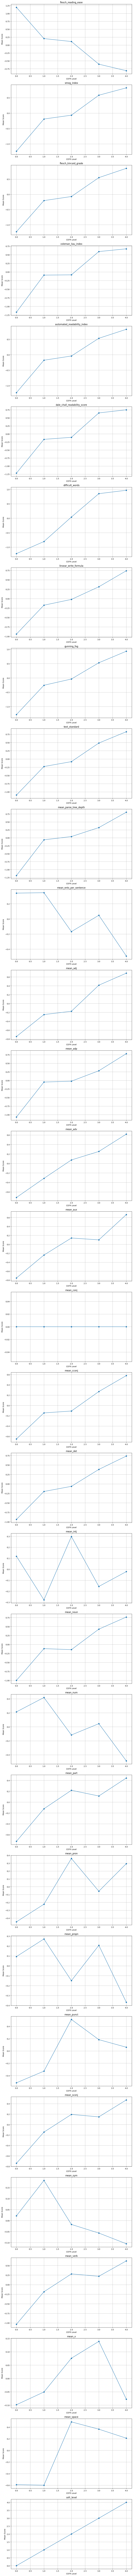

In [17]:
import matplotlib.pyplot as plt

# Calculate mean scores for each column grouped by 'cefr_level'
mean_scores = {}
for column in preproc_data.columns:
    mean = preproc_data.groupby("cefr_level")[column].mean()
    mean_scores[column] = mean

# Create subplots with appropriate figure size
fig, axs = plt.subplots(len(mean_scores), figsize=(10, 6 * len(mean_scores)))

# Plot each mean score on separate subplots
for i, (title, data) in enumerate(mean_scores.items()):
    ax = axs[i] if len(mean_scores) > 1 else axs  # Handle single subplot case
    ax.plot(data.index, data.values, marker='o', linestyle='-')
    ax.set_title(title)
    ax.set_xlabel('CEFR Level')
    ax.set_ylabel('Mean Score')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [24]:
data = pd.read_csv('data/cefr_readings.csv')
new_data = pd.concat([data[["documents"]], preproc_data], axis=1)

In [25]:
new_data

,documents,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog,...,mean_part,mean_pron,mean_propn,mean_punct,mean_sconj,mean_sym,mean_verb,mean_x,mean_space,cefr_level
0,The Long Night This is David Reilly's first bo...,-0.462212,0.567366,0.644332,0.296326,0.631550,0.952602,0.092505,-0.170928,0.858509,...,0.820268,-0.302404,-0.436874,0.374125,0.606276,-0.151259,0.954803,-0.145348,0.882183,4
1,Most house burglaries happen between 2 p.m. an...,0.244419,-0.072709,0.135932,-0.379699,0.180702,-0.314813,-0.289365,0.494831,0.328819,...,0.419550,1.871286,-0.507837,2.243496,0.007789,-0.151259,0.753226,-0.145348,-0.137023,2
2,One very famous place for tourists in London i...,1.105167,-1.694233,-1.425584,-0.767229,-1.292067,-0.491662,-1.191967,-1.416850,-1.605085,...,-1.806661,-1.018131,-0.844912,-0.830580,-0.866924,-0.151259,-1.884080,-0.145348,-1.156230,0
3,To: All staff Subject: Holidays From: D Brown ...,0.666702,-0.798128,-0.626669,-0.280663,-0.510598,-0.884659,-1.157252,-0.687232,-0.943860,...,-0.693556,-1.349487,1.514614,-0.124374,-1.649561,-0.151259,-0.775404,-0.145348,-1.156230,0
4,Canada Geese are large blue and white birds. W...,0.768420,-1.224845,-0.844555,-0.909323,-0.871276,-0.020065,0.352870,0.380701,-0.979410,...,-0.827128,0.466340,-0.525578,2.118871,-0.360511,-0.151259,0.081301,-0.145348,0.882183,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,"Some time ago, a website highlighted the risks...",0.753008,-0.414083,-0.808240,-0.384005,-0.570711,-0.393413,-0.219934,-0.687232,-0.570589,...,0.018832,0.201256,-0.259466,1.454206,-0.452586,-0.151259,-0.792202,-0.145348,0.117778,2
327,"A course at the Bamboo Bike Club, run by engin...",0.038671,0.140649,-0.263526,-0.056757,-0.390372,-0.118315,0.005716,-0.524188,-0.371510,...,0.063356,0.028951,-0.791690,-0.705956,-0.268436,-0.151259,-0.489835,0.856950,0.117778,2
328,The two sisters kept Lily's driving a secret f...,0.127289,-0.030038,0.317503,0.347997,0.751776,0.824878,-0.115788,1.065482,0.588331,...,0.285977,-0.766301,1.461391,1.828080,0.698351,-0.151259,0.954803,-0.145348,0.882183,2
329,I have never begun a novel with more misgiving...,0.557278,-0.158053,-0.445097,-0.556240,-0.390372,-1.012383,-0.167861,-0.408699,-0.314631,...,0.597647,2.176133,-1.164246,-0.207457,1.250801,-0.151259,1.441949,-0.145348,0.882183,2


In [26]:
new_data.to_csv("data/cefr_readings_with_new_features.csv",index=False)